In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import geopandas as gpd
import scanpy as sc

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


2024-07-15 19:51:53.329684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model = StarDist2D.from_pretrained('2D_versatile_he')

min_percentile = 5
max_percentile = 95
img = normalize(cropped_img, min_percentile, max_percentile)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [16]:
labels, polys = model.predict_instances_big(img,
                                            axes='YXC',
                                            block_size=4096,
                                            prob_thresh=0.01,
                                            nms_thresh=0.001,
                                            min_overlap=128,
                                            context=128,
                                            normalizer=None,
                                            n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 49/49 [30:07<00:00, 36.88s/it]


In [17]:
# Creating a list to store Polygon geometries
geometries = []

# Iterating through each nuclei in the 'polys' DataFrame
for nuclei in range(len(polys['coord'])):

    # Extracting coordinates for the current nuclei and converting them to (y, x) format
    # common in GIS and spatial data
    coords = [(y, x) for x, y in zip(polys['coord'][nuclei][0], polys['coord'][nuclei][1])]

    # Creating a Polygon geometry from the coordinates
    geometries.append(Polygon(coords))

# Creating a GeoDataFrame using the Polygon geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


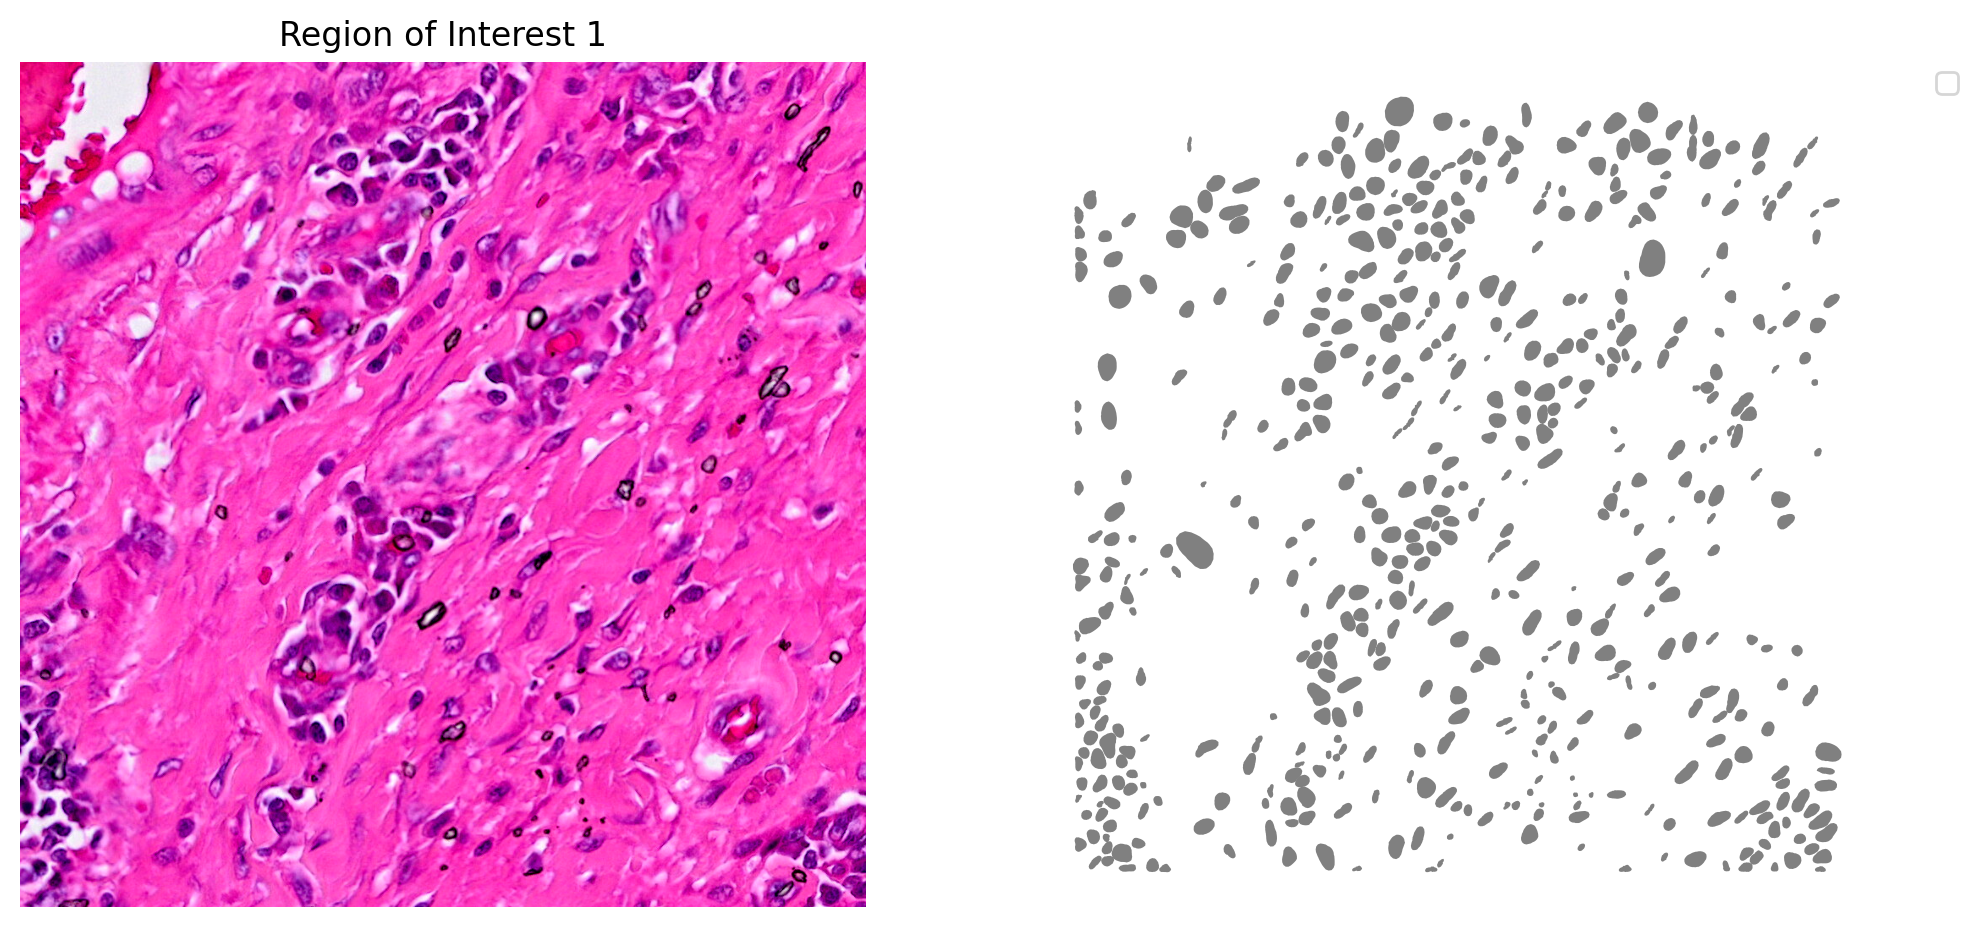

In [19]:
# Plot the nuclei segmentation
# bbox=(x min,y min,x max,y max)

# Define a single color cmap
cmap=ListedColormap(['grey'])

# Create Plot
plot_mask_and_save_image(title="Region of Interest 1",
                         gdf=gdf,
                         bbox=(0,0,1000,1000),
                         cmap=cmap,
                         img=img,
                         output_name=dir_base+"p5_image_mask.ROI1.tif")


In [20]:
def plot_mask_and_save_image3(title, gdf, img, cmap, output_name=None, bbox=None):
    if bbox is not None:
        # Crop the image to the bounding box
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    # Plot options
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the cropped image
    ax.imshow(cropped_img, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.axis('off')

    # Create filtering polygon
    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
        # Filter for polygons in the box
        intersects_bbox = gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = gdf[intersects_bbox]
    else:
        filtered_gdf = gdf

    # Overlay the filtered polygons on the image
    for poly in filtered_gdf['geometry']:
        x, y = poly.exterior.xy
        ax.plot(x, y, color='red', linewidth=1)  # Change color and linewidth as needed

    # Save the plot if output_name is provided
    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')
    else:
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


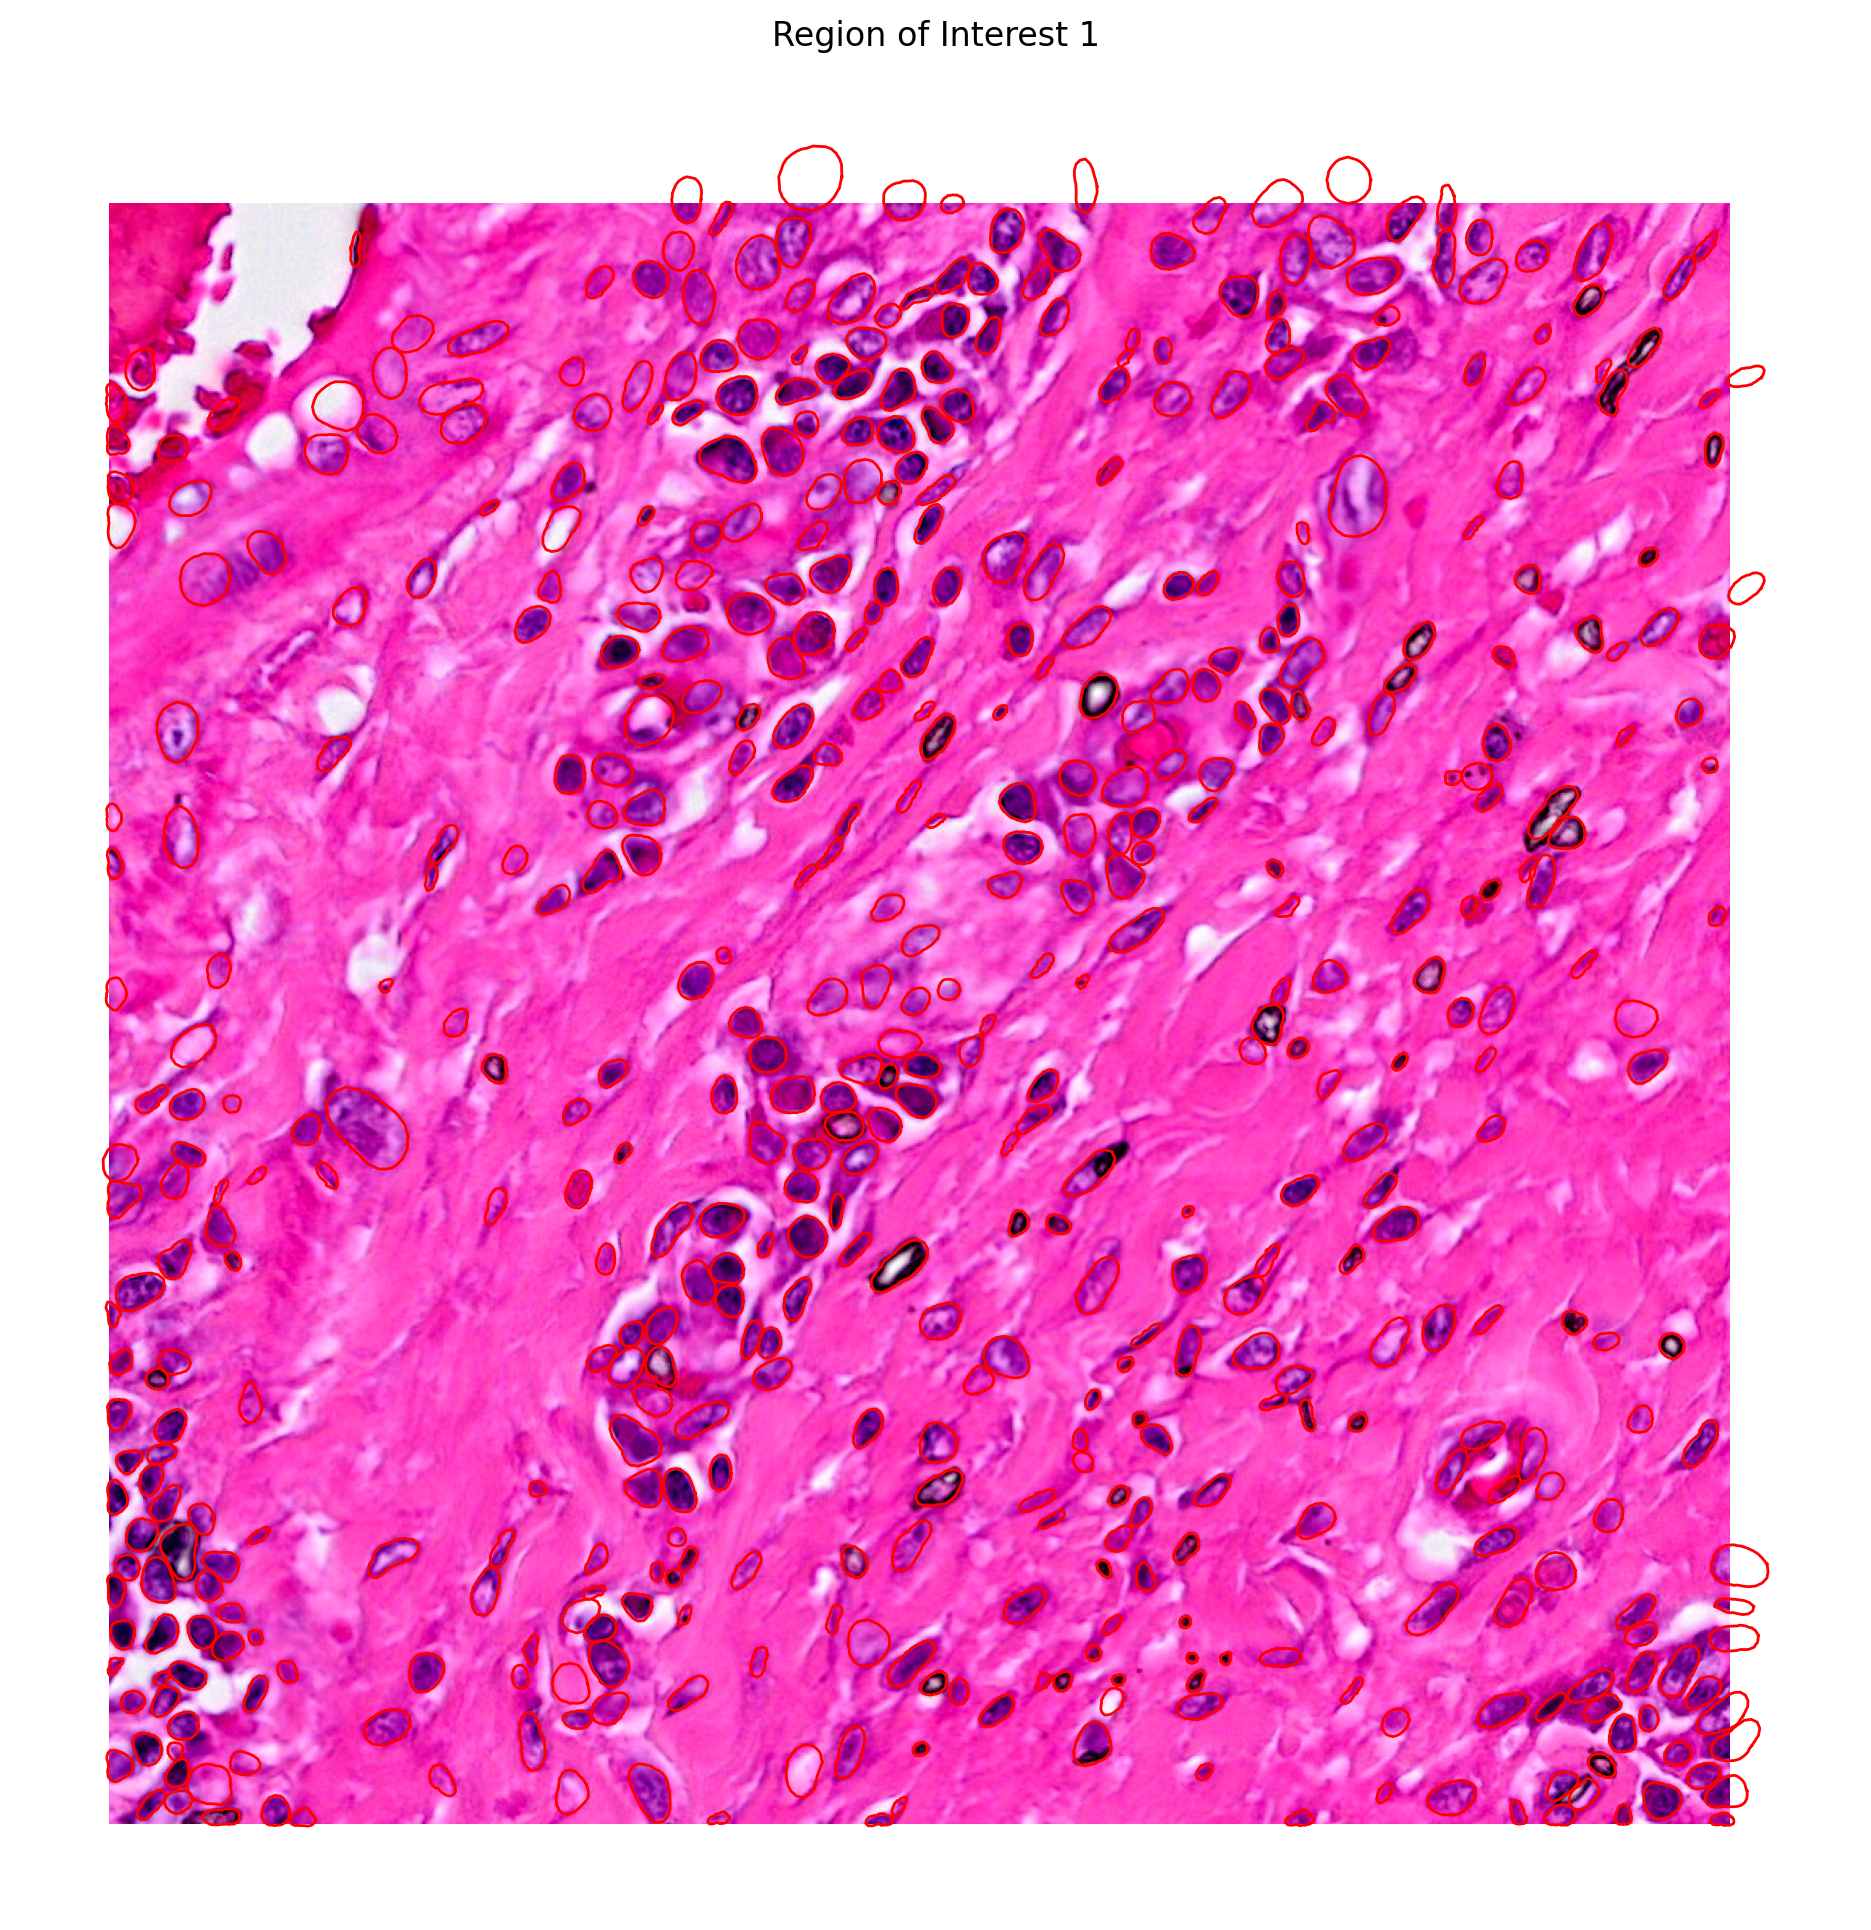

In [22]:
cmap = ListedColormap(['grey'])

# Define the output directory and file name
dir_base = '../data/human/p5/'
output_name = dir_base + "p5_overlay_image_mask.ROI1.tif"

# Create the plot
plot_mask_and_save_image(
    title="Region of Interest 1",
    gdf=gdf,
    bbox=(0, 0, 1000, 1000),
    cmap=cmap,
    img=img,
    output_name=output_name
)


In [23]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe, read_microns_per_pixel, calculate_one_micron, get_barcode_coordinates, read_image, crop_image, save_image_as_btf

# Load the DataFrame
df = load_dataframe('../data/raw/p5/binned_outputs/square_002um/spatial/tissue_positions.parquet')

# Read microns_per_pixel from JSON file
json_path = '/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/raw/p5/binned_outputs/square_002um/spatial/scalefactors_json.json'
microns_per_pixel = read_microns_per_pixel(json_path)
one_micron = calculate_one_micron(microns_per_pixel)

# Get barcode coordinates
first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col = get_barcode_coordinates(df, one_micron)

# Read the image
dir_base = '../data/raw/p5/'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
img = read_image(dir_base + filename)

# Crop the image using the calculated coordinates
cropped_img = crop_image(img, first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col)

print(cropped_img.shape)

output_filename = 'p5_cropped_image.btf'
output_dir = '../data/processed'
output_path = os.path.join(output_dir, output_filename)
save_image_as_btf(cropped_img, output_path)


(24356, 24573, 3)
Cropped image saved as ../data/processed/cropped_image.btf


In [25]:
import sys
sys.path.append('../utils')

# Importing importlib for module reloading
import importlib
import image_segmentation, geodataframe_creation

# Reloading the module
importlib.reload(image_cropp_utils)

from skimage.io import imread
from image_segmentation import segment_image
from geodataframe_creation import create_geodataframe

# Assuming you have loaded 'cropped_img' using imread or some other method
#cropped_img = read your btf from previous step

# Perform image segmentation
polys = segment_image(cropped_img)

# Create GeoDataFrame from segmented polygons
gdf = create_geodataframe(polys)

# Now 'gdf' contains the GeoDataFrame with polygons and IDs
print(gdf.head())


2024-07-17 09:13:49.014206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 49/49 [43:13<00:00, 52.93s/it]   


                                            geometry    id
0  POLYGON ((2910.060 162.000, 2911.146 165.013, ...  ID_1
1  POLYGON ((3403.370 1818.000, 3403.707 1820.329...  ID_2
2  POLYGON ((621.480 694.000, 621.919 696.371, 62...  ID_3
3  POLYGON ((3203.587 2860.000, 3203.912 2861.971...  ID_4
4  POLYGON ((1580.603 374.000, 1580.050 376.397, ...  ID_5


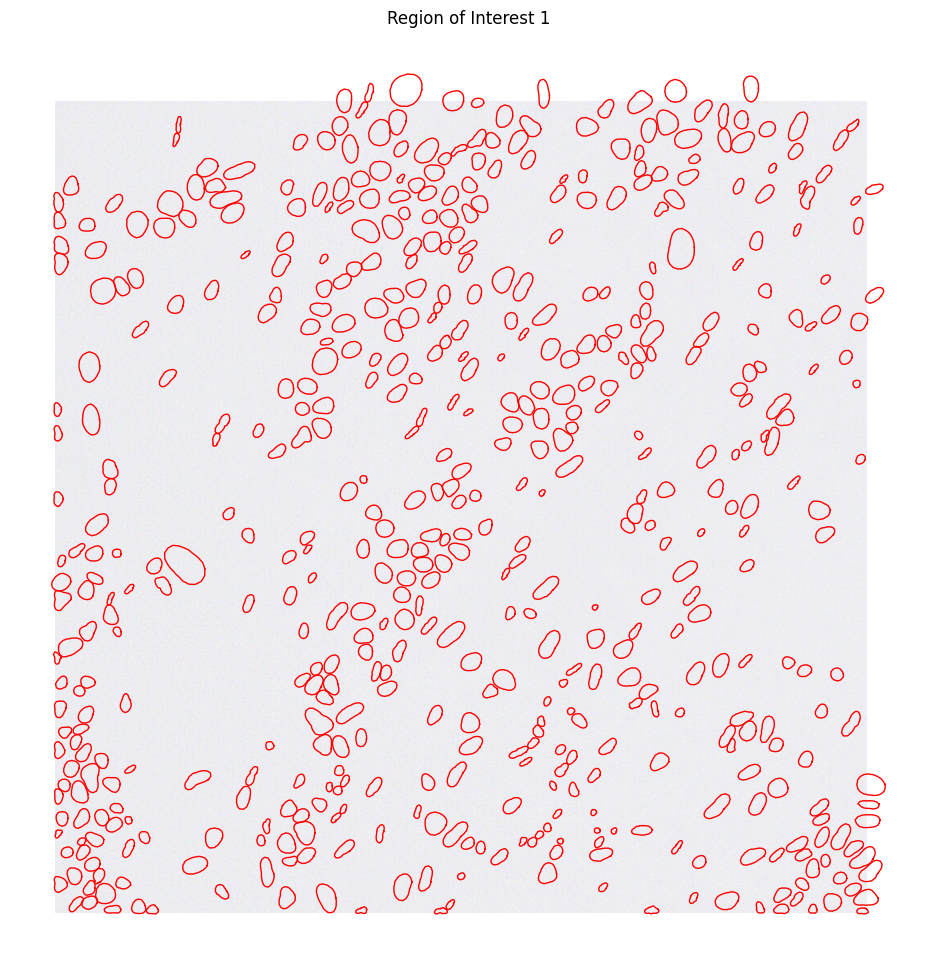

In [34]:
import sys
sys.path.append('../utils')  # Adjust the path as needed


import importlib
import image_plot_utils

# Reloading the module
importlib.reload(image_plot_utils)
from image_plot_utils import plot_mask_and_save_image2

# Create Plot
plot_mask_and_save_image2(title="Region of Interest 1",
                         gdf=gdf,
                         bbox=(0,0,1000,1000),
                         img=img,
                         output_name=dir_base+"p5_image_mask.ROI1.tif")
